In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import itertools
import warnings

In [33]:
warnings.filterwarnings("ignore")

In [3]:
os.chdir("D:\Personal Projects\Energy Timeseries Project")

In [4]:
# Read in data
energy_data = pd.read_csv('US_government_energy_data.csv')

In [5]:
# Look over the data
print(energy_data.head())
print(energy_data.info())
print(energy_data.describe())

       MSN  YYYYMM     Value  Column_Order                    Description  \
0  FFPRBUS  197301  4.932632             1  Total Fossil Fuels Production   
1  FFPRBUS  197302  4.729582             1  Total Fossil Fuels Production   
2  FFPRBUS  197303  4.946902             1  Total Fossil Fuels Production   
3  FFPRBUS  197304  4.716271             1  Total Fossil Fuels Production   
4  FFPRBUS  197305  4.956995             1  Total Fossil Fuels Production   

              Unit  
0  Quadrillion Btu  
1  Quadrillion Btu  
2  Quadrillion Btu  
3  Quadrillion Btu  
4  Quadrillion Btu  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8244 entries, 0 to 8243
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSN           8244 non-null   object 
 1   YYYYMM        8244 non-null   int64  
 2   Value         8244 non-null   float64
 3   Column_Order  8244 non-null   int64  
 4   Description   8244 non-null   object 
 5  

In [6]:
# Rename the "YYYYMM" column to "date"
energy_data.rename(columns={'YYYYMM': 'Date'}, inplace=True)

In [7]:
# Convert the "date" column to datetime format
energy_data['Date'] = pd.to_datetime(energy_data['Date'], format='%Y%m', errors='coerce')

In [8]:
# Set the "Date" column as the index
energy_data.set_index('Date', inplace=True)

In [9]:
# Check date conversion results
print(energy_data.head())

                MSN     Value  Column_Order                    Description  \
Date                                                                         
1973-01-01  FFPRBUS  4.932632             1  Total Fossil Fuels Production   
1973-02-01  FFPRBUS  4.729582             1  Total Fossil Fuels Production   
1973-03-01  FFPRBUS  4.946902             1  Total Fossil Fuels Production   
1973-04-01  FFPRBUS  4.716271             1  Total Fossil Fuels Production   
1973-05-01  FFPRBUS  4.956995             1  Total Fossil Fuels Production   

                       Unit  
Date                         
1973-01-01  Quadrillion Btu  
1973-02-01  Quadrillion Btu  
1973-03-01  Quadrillion Btu  
1973-04-01  Quadrillion Btu  
1973-05-01  Quadrillion Btu  


In [10]:
# Filter out rows with NaT values in the Date column
energy_data = energy_data[energy_data.index.notnull()]

In [11]:
# Filter the data for "Primary Energy Imports" or "Primary Energy Exports"
filtered_energy_data = energy_data[(energy_data['Description'] == 'Primary Energy Imports') |
                            (energy_data['Description'] == 'Primary Energy Exports')]

In [12]:
# Separate the data into two different DataFrames for imports and exports
imports_data = filtered_energy_data[filtered_energy_data['Description'] == 'Primary Energy Imports']
exports_data = filtered_energy_data[filtered_energy_data['Description'] == 'Primary Energy Exports']

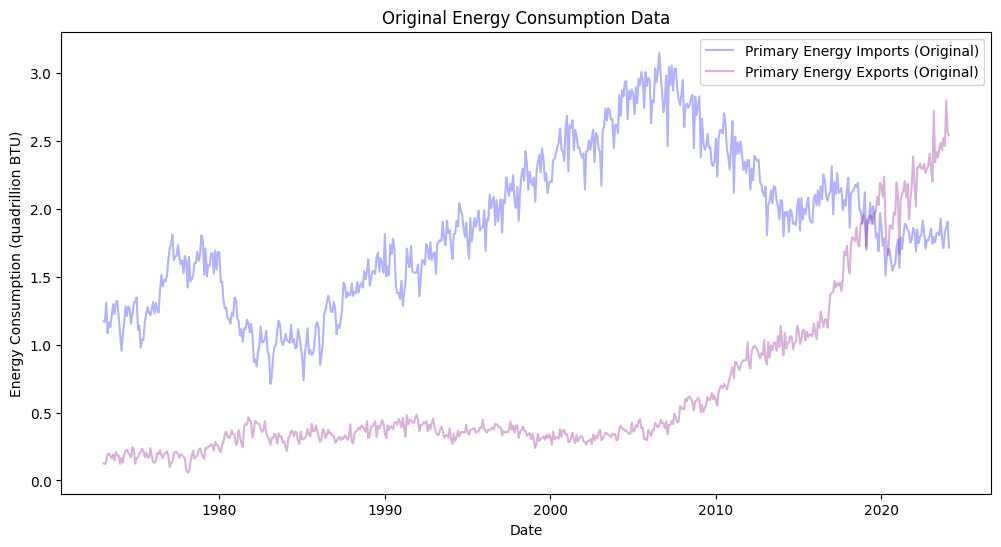

In [13]:
# Visualize original data to identify anomalies
plt.figure(figsize=(12, 6))
plt.plot(imports_data['Value'], label='Primary Energy Imports (Original)', color='blue', alpha=0.3)
plt.plot(exports_data['Value'], label='Primary Energy Exports (Original)', color='purple', alpha=0.3)
plt.title('Original Energy Consumption Data')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (quadrillion BTU)')
plt.legend()
plt.show()

In [14]:
# Apply rolling average to smooth the time series data (e.g., window size of 12 months)
imports_data['Smoothed_Value'] = imports_data['Value'].rolling(window=6).mean()
exports_data['Smoothed_Value'] = exports_data['Value'].rolling(window=6).mean()

C:\Users\james\AppData\Local\Temp\ipykernel_20620\3522829696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imports_data['Smoothed_Value'] = imports_data['Value'].rolling(window=6).mean()
C:\Users\james\AppData\Local\Temp\ipykernel_20620\3522829696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exports_data['Smoothed_Value'] = exports_data['Value'].rolling(window=6).mean()


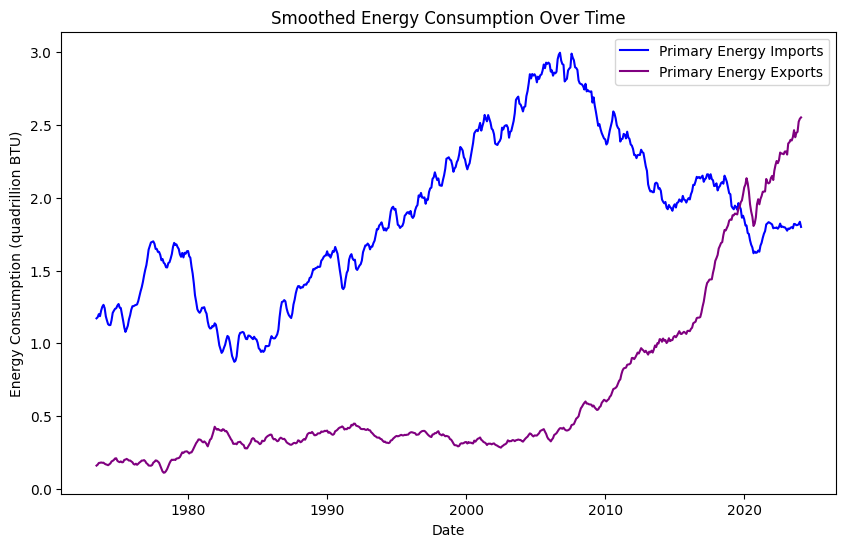

In [15]:
# Plot the smoothed time series data with different colors
plt.figure(figsize=(10, 6))
plt.plot(imports_data['Smoothed_Value'], label='Primary Energy Imports', color='blue')
plt.plot(exports_data['Smoothed_Value'], label='Primary Energy Exports', color='purple')
plt.title('Smoothed Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (quadrillion BTU)')
plt.legend()
plt.show()

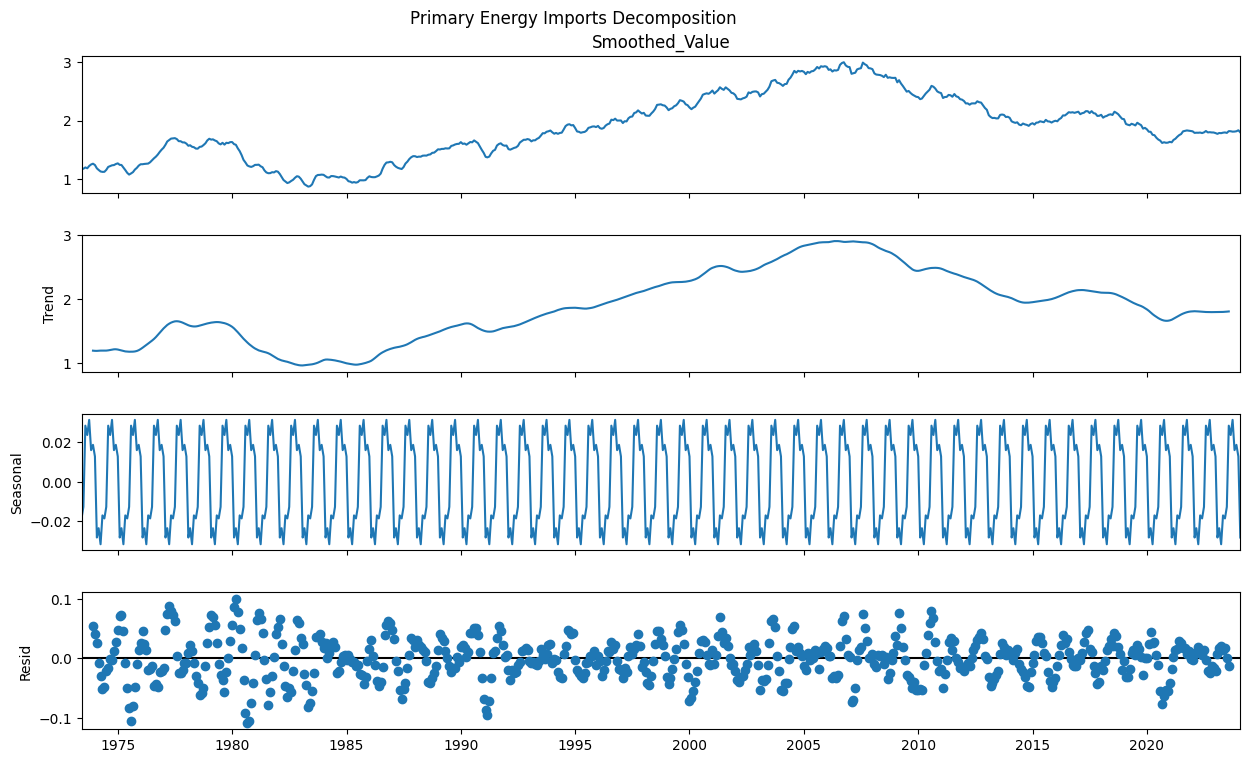

In [16]:
# Time Series Decomposition for Imports
decomposition_imports = seasonal_decompose(imports_data['Smoothed_Value'].dropna(), model='additive', period=12)
fig_imports = decomposition_imports.plot()
fig_imports.set_size_inches(14, 8)
plt.suptitle('Primary Energy Imports Decomposition')
plt.show()

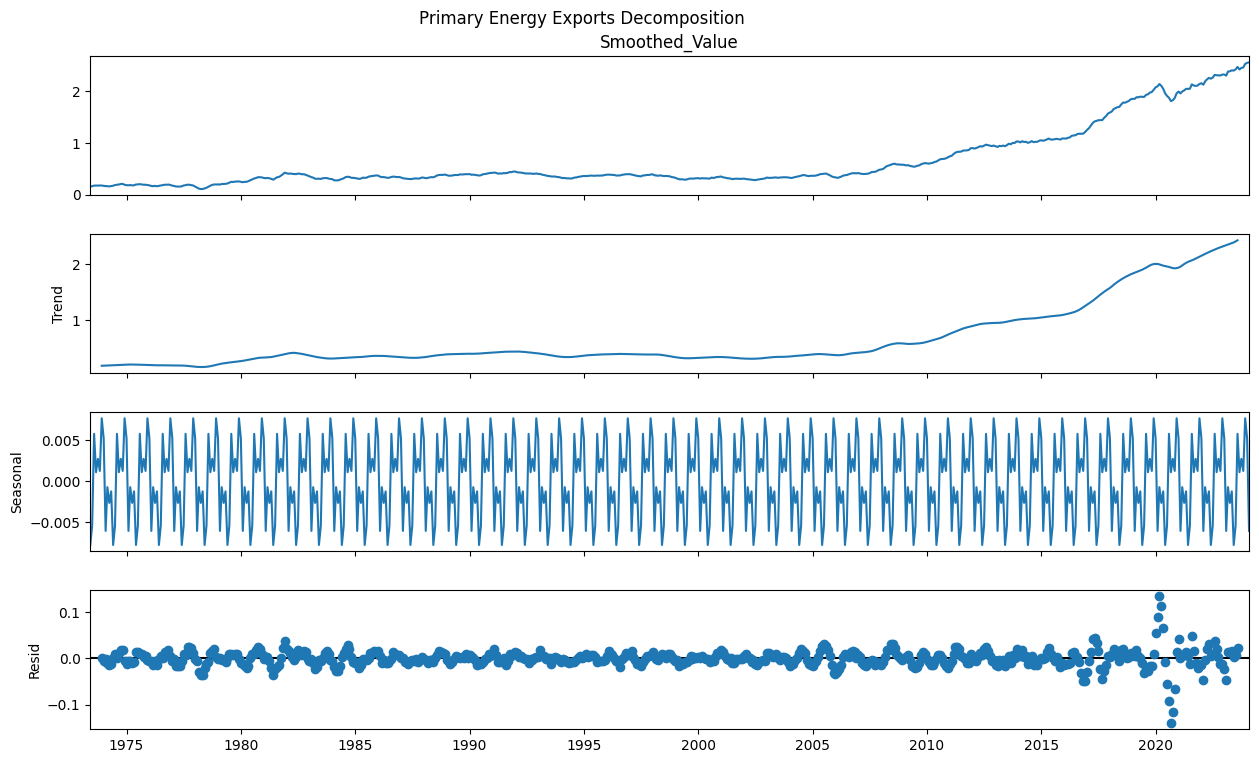

In [17]:
# Time Series Decomposition for Exports
decomposition_exports = seasonal_decompose(exports_data['Smoothed_Value'].dropna(), model='additive', period=12)
fig_exports = decomposition_exports.plot()
fig_exports.set_size_inches(14, 8)
plt.suptitle('Primary Energy Exports Decomposition')
plt.show()

In [18]:
# Check for stationarity using the Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


In [19]:

print("Stationarity check for Primary Energy Imports:")
check_stationarity(imports_data['Value'])

print("Stationarity check for Primary Energy Exports:")
check_stationarity(exports_data['Value'])

Stationarity check for Primary Energy Imports:
ADF Statistic: -1.574295
p-value: 0.496492
	1%: -3.441
	5%: -2.866
	10%: -2.569
Stationarity check for Primary Energy Exports:
ADF Statistic: 3.186318
p-value: 1.000000
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [20]:

# If data is not stationary, apply differencing
imports_data['Differenced_Value'] = imports_data['Value'].diff().dropna()
exports_data['Differenced_Value'] = exports_data['Value'].diff().dropna()

C:\Users\james\AppData\Local\Temp\ipykernel_20620\1785674894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imports_data['Differenced_Value'] = imports_data['Value'].diff().dropna()
C:\Users\james\AppData\Local\Temp\ipykernel_20620\1785674894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exports_data['Differenced_Value'] = exports_data['Value'].diff().dropna()


In [21]:
# Re-check stationarity after differencing
print("Stationarity check for differenced Primary Energy Imports:")
check_stationarity(imports_data['Differenced_Value'])

print("Stationarity check for differenced Primary Energy Exports:")
check_stationarity(exports_data['Differenced_Value'])

Stationarity check for differenced Primary Energy Imports:
ADF Statistic: -6.564467
p-value: 0.000000
	1%: -3.441
	5%: -2.866
	10%: -2.569
Stationarity check for differenced Primary Energy Exports:
ADF Statistic: -3.588030
p-value: 0.005994
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [ ]:
# ARIMA Modeling & Tuning

In [22]:
# Function to evaluate ARIMA model performance
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

In [23]:
# Perform grid search over a range of ARIMA parameters
def grid_search_arima(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(data, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [24]:
# Define the p, d, q ranges to search over
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

In [ ]:
# Tune ARIMA model for imports data
print("Tuning ARIMA model for Primary Energy Imports")
best_order_imports = grid_search_arima(imports_data['Value'].dropna(), p_values, d_values, q_values)
print("Best ARIMA order for imports data:", best_order_imports)

In [ ]:
# Tune ARIMA model for exports data
print("Tuning ARIMA model for Primary Energy Exports")
best_order_exports = grid_search_arima(exports_data['Value'].dropna(), p_values, d_values, q_values)
print("Best ARIMA order for exports data:", best_order_exports)

In [27]:
# Function to fit ARIMA and forecast
def fit_arima_and_forecast(data, order, steps):
    # Split data into train and test sets
    train = data[:-steps]
    test = data[-steps:]

       # Fit ARIMA model
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.forecast(steps=steps)
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='blue')
    plt.plot(forecast.index, forecast, label='Forecast', color='red')
    plt.title('ARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (quadrillion BTU)')
    plt.legend()
    plt.show()
    
    return model_fit, forecast

In [34]:
# Define ARIMA order (p, d, q) - this will need tuning
arima_export_order = (3,0,3)

In [35]:
arima_import_order = (3,1,3)

In [36]:
# Number of steps to forecast
forecast_steps = 36

ARIMA Model for Primary Energy Imports


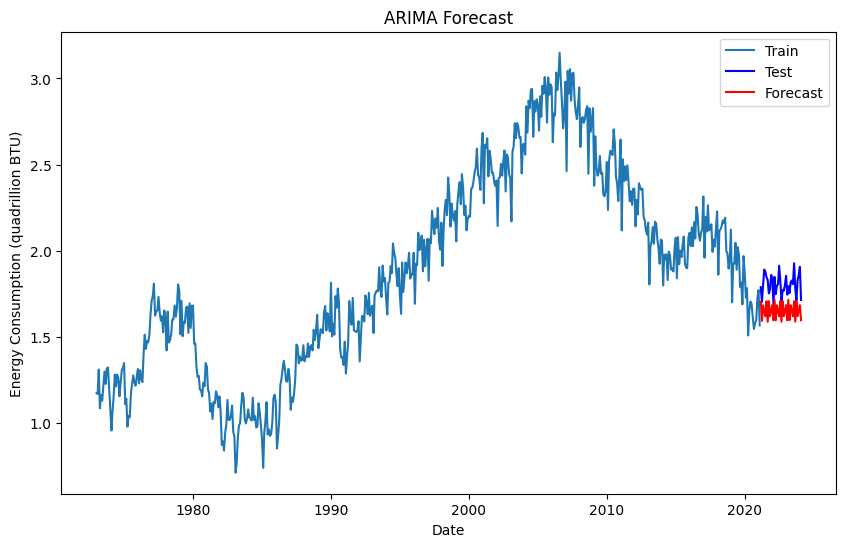

In [37]:
# Fit ARIMA and forecast for imports
print("ARIMA Model for Primary Energy Imports")
model_imports, forecast_imports = fit_arima_and_forecast(imports_data['Value'].dropna(), arima_import_order, forecast_steps)

ARIMA Model for Primary Energy Exports


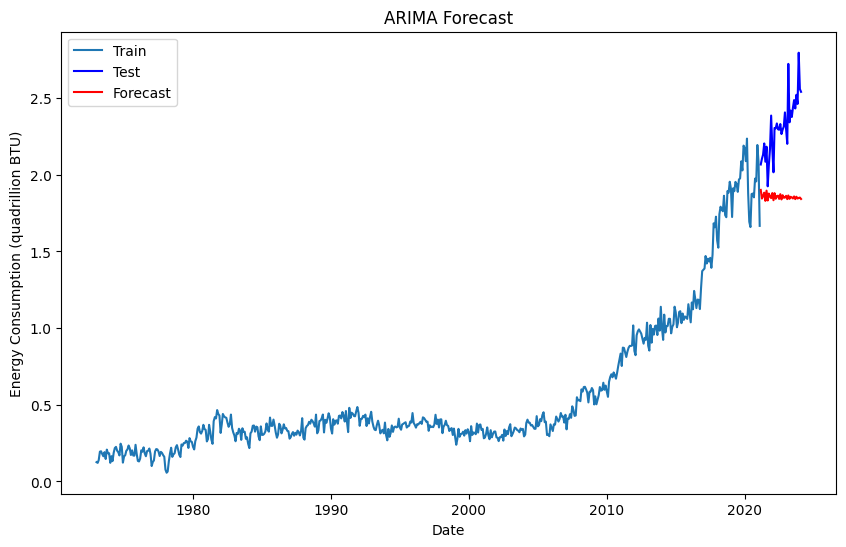

In [38]:

# Fit ARIMA and forecast for exports
print("ARIMA Model for Primary Energy Exports")
model_exports, forecast_exports = fit_arima_and_forecast(exports_data['Value'].dropna(), arima_export_order, forecast_steps)

In [43]:
# Assuming these are the best ARIMA parameters derived from previous grid search
best_order_imports = (3, 1, 3)
best_order_exports = (3, 0, 3)

# Seasonal components
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, m) where m=12 for monthly data

In [42]:
# Function to fit SARIMA and forecast
def fit_sarima_and_forecast(data, order, seasonal_order, steps):
    # Split data into train and test sets
    train = data[:-steps]
    test = data[-steps:]
    
    # Fit SARIMA model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    
    # Forecast
    forecast = model_fit.get_forecast(steps=steps)
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='blue')
    plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title('SARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (quadrillion BTU)')
    plt.legend()
    plt.show()
    
    return model_fit, forecast_values

In [ ]:
# Number of steps to forecast
forecast_steps = 12

SARIMA Model for Primary Energy Imports


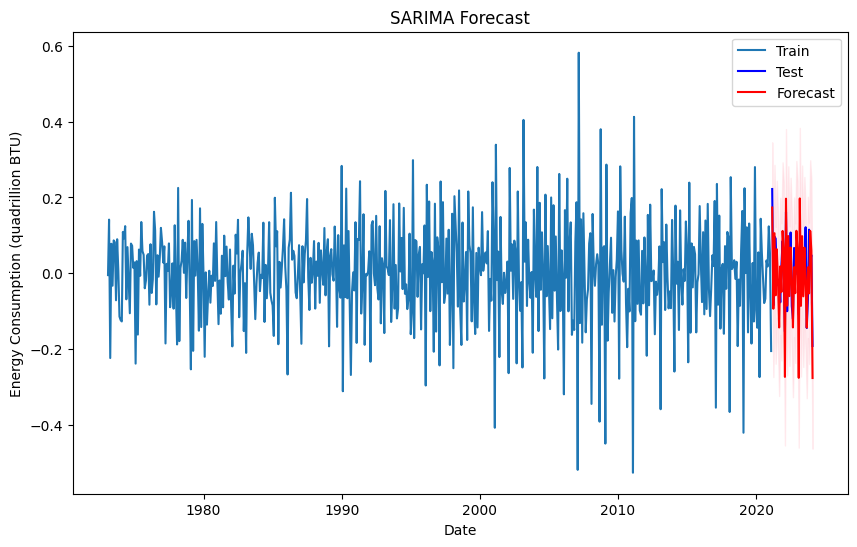

In [44]:
# Fit SARIMA and forecast for imports with the best order
print("SARIMA Model for Primary Energy Imports")
model_imports, forecast_imports = fit_sarima_and_forecast(imports_data['Differenced_Value'].dropna(), best_order_imports, seasonal_order, forecast_steps)